In [1]:
import numpy as np
import scipy as sp
import scipy.stats as sps
import pandas as pd
import matplotlib.pyplot as plt
import pytensor.tensor as pt

import arviz as az
import pymc as pm

# 1

In [213]:
data = sps.norm.rvs(size=1000, random_state=1337)
data = data[(data > -1) & (data < 2)]

In [214]:
data_min = data.min()
data_max = data.max()

with pm.Model() as model:
    mu = pm.Flat('mu')
    sigma = pm.HalfFlat('sigma')
    pm.Potential('p(mu, sigma)', pm.math.log(1/sigma))
    
    lower = data_min - pm.Exponential('L', lam=1.)
    upper = data_max + pm.Exponential('U', lam=1.)
    normal_dist = pm.Normal.dist(mu=mu, sigma=sigma)
    trunc_normal = pm.Truncated('trunc_N', normal_dist, lower, upper, observed=data)
    
    trace = pm.sample(draws=10**4, chains=1)

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu, sigma, L, U]


Output()

Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 11 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


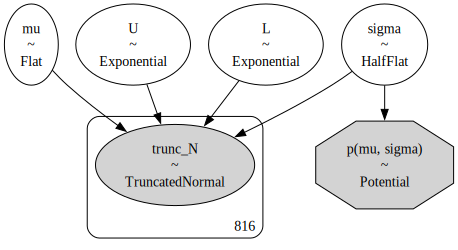

In [215]:
pm.model_to_graphviz(model)

In [216]:
hdi_sigma = az.hdi(trace, hdi_prob=0.95).sigma
print(f'sigma hdi: [{float(hdi_sigma[0]):5f}; {float(hdi_sigma[1]):.5f}]')

sigma hdi: [0.894754; 1.16938]


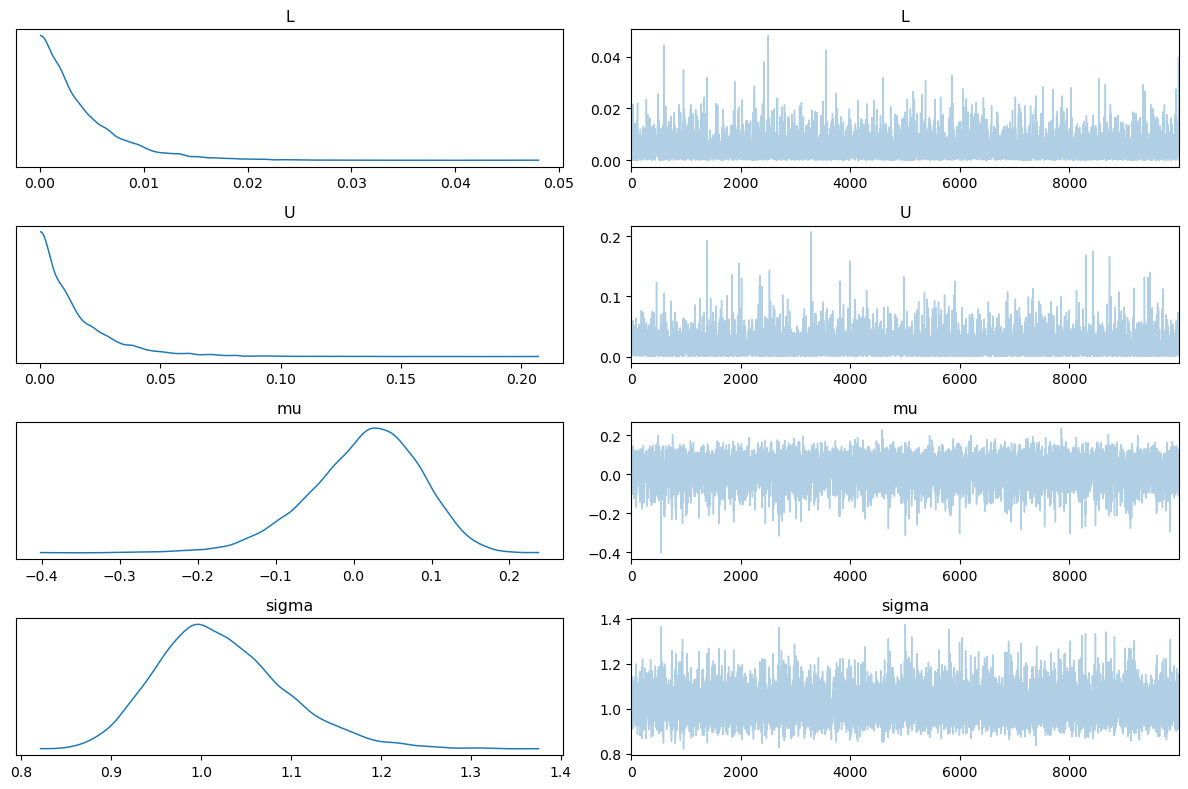

In [217]:
az.plot_trace(trace)
plt.tight_layout()

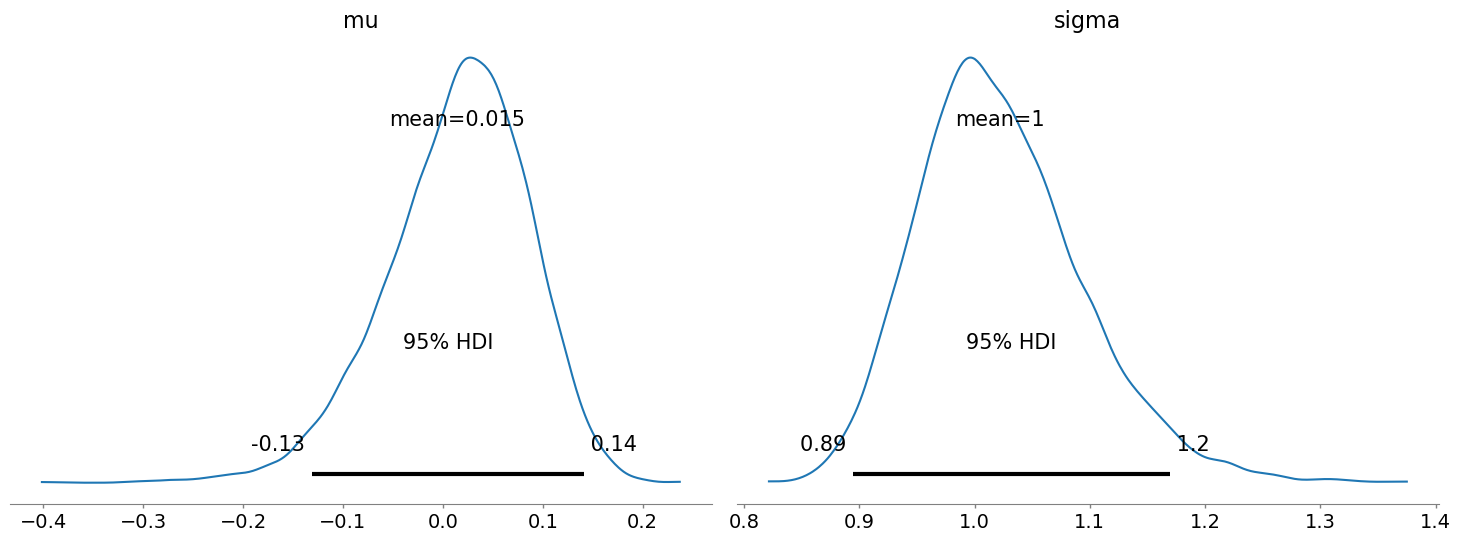

In [218]:
az.plot_posterior(trace, var_names=["mu", "sigma"], grid=(1, 2), hdi_prob=0.95)
plt.tight_layout()

In [221]:
with model:
    pm.sample_posterior_predictive(trace, var_names=["trunc_N"], extend_inferencedata=True)

C:\Users\nazmievairat\AppData\Local\Temp\ipykernel_16044\491103110.py:2: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  pm.sample_posterior_predictive(trace, var_names=["trunc_N"], extend_inferencedata=True)
Sampling: [trunc_N]


Output()

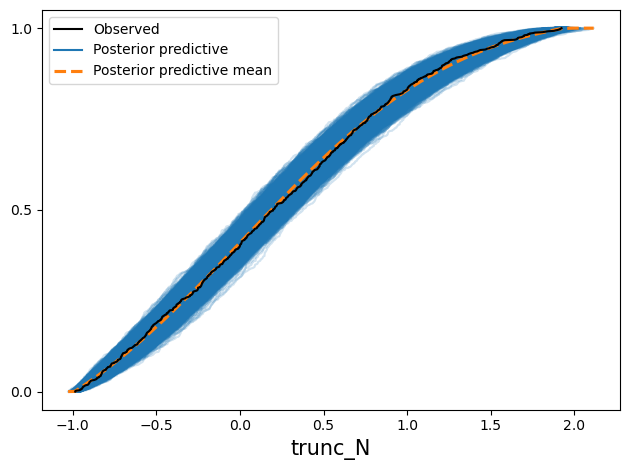

In [224]:
az.plot_ppc(trace, kind='cumulative')
plt.legend(loc='upper left')
plt.tight_layout()

# 2

In [14]:
euro = pd.read_csv('https://stepik.org/media/attachments/lesson/1251114/euroweight.dat.txt', sep='\t', names=['weight', 'batch'], index_col=0)
print(euro.head())

   weight  batch
1   7.512      1
2   7.502      1
3   7.461      1
4   7.562      1
5   7.528      1


In [15]:
euro_weights = euro.weight.values
euro_batch_idx = euro.batch.values - 1

In [16]:
with pm.Model() as model:
    mu_b = pm.Normal('mu_b', mu=0, sigma=100)
    sigma_b = pm.HalfNormal('sigma_b', 5)
    sigma = pm.HalfNormal('sigma', 10)
    
    mu_batch = pm.Normal('mu_batch', mu=mu_b, sigma=sigma_b, shape=8)
    
    weight = pm.Normal('weight', mu=mu_batch[euro_batch_idx], sigma=sigma, observed=euro_weights)

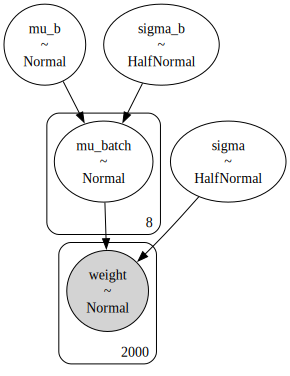

In [17]:
pm.model_to_graphviz(model)

In [18]:
with model:
    trace = pm.sample(draws=10**4, chains=1, nuts_sampler='numpyro')

sample: 100%|██████████| 11000/11000 [00:16<00:00, 673.30it/s, 7 steps of size 3.85e-01. acc. prob=0.88]
Only one chain was sampled, this makes it impossible to run some convergence checks


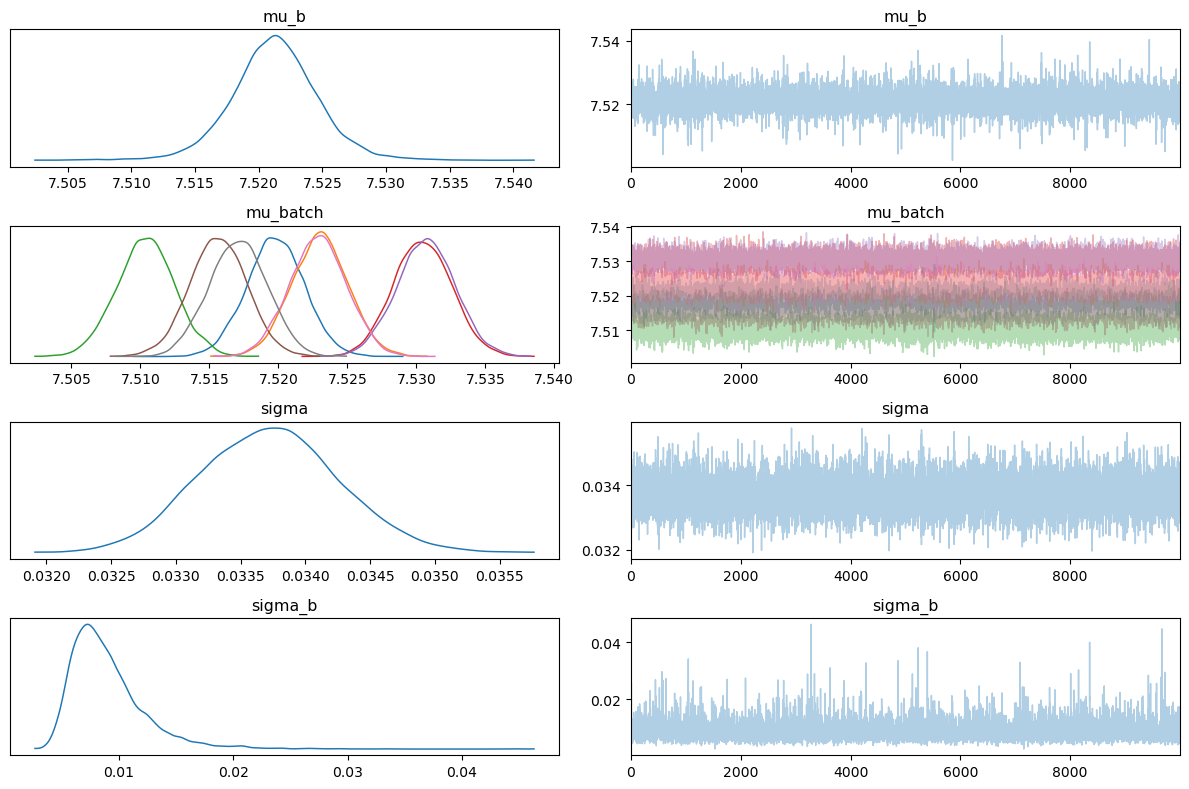

In [19]:
az.plot_trace(trace)
plt.tight_layout()

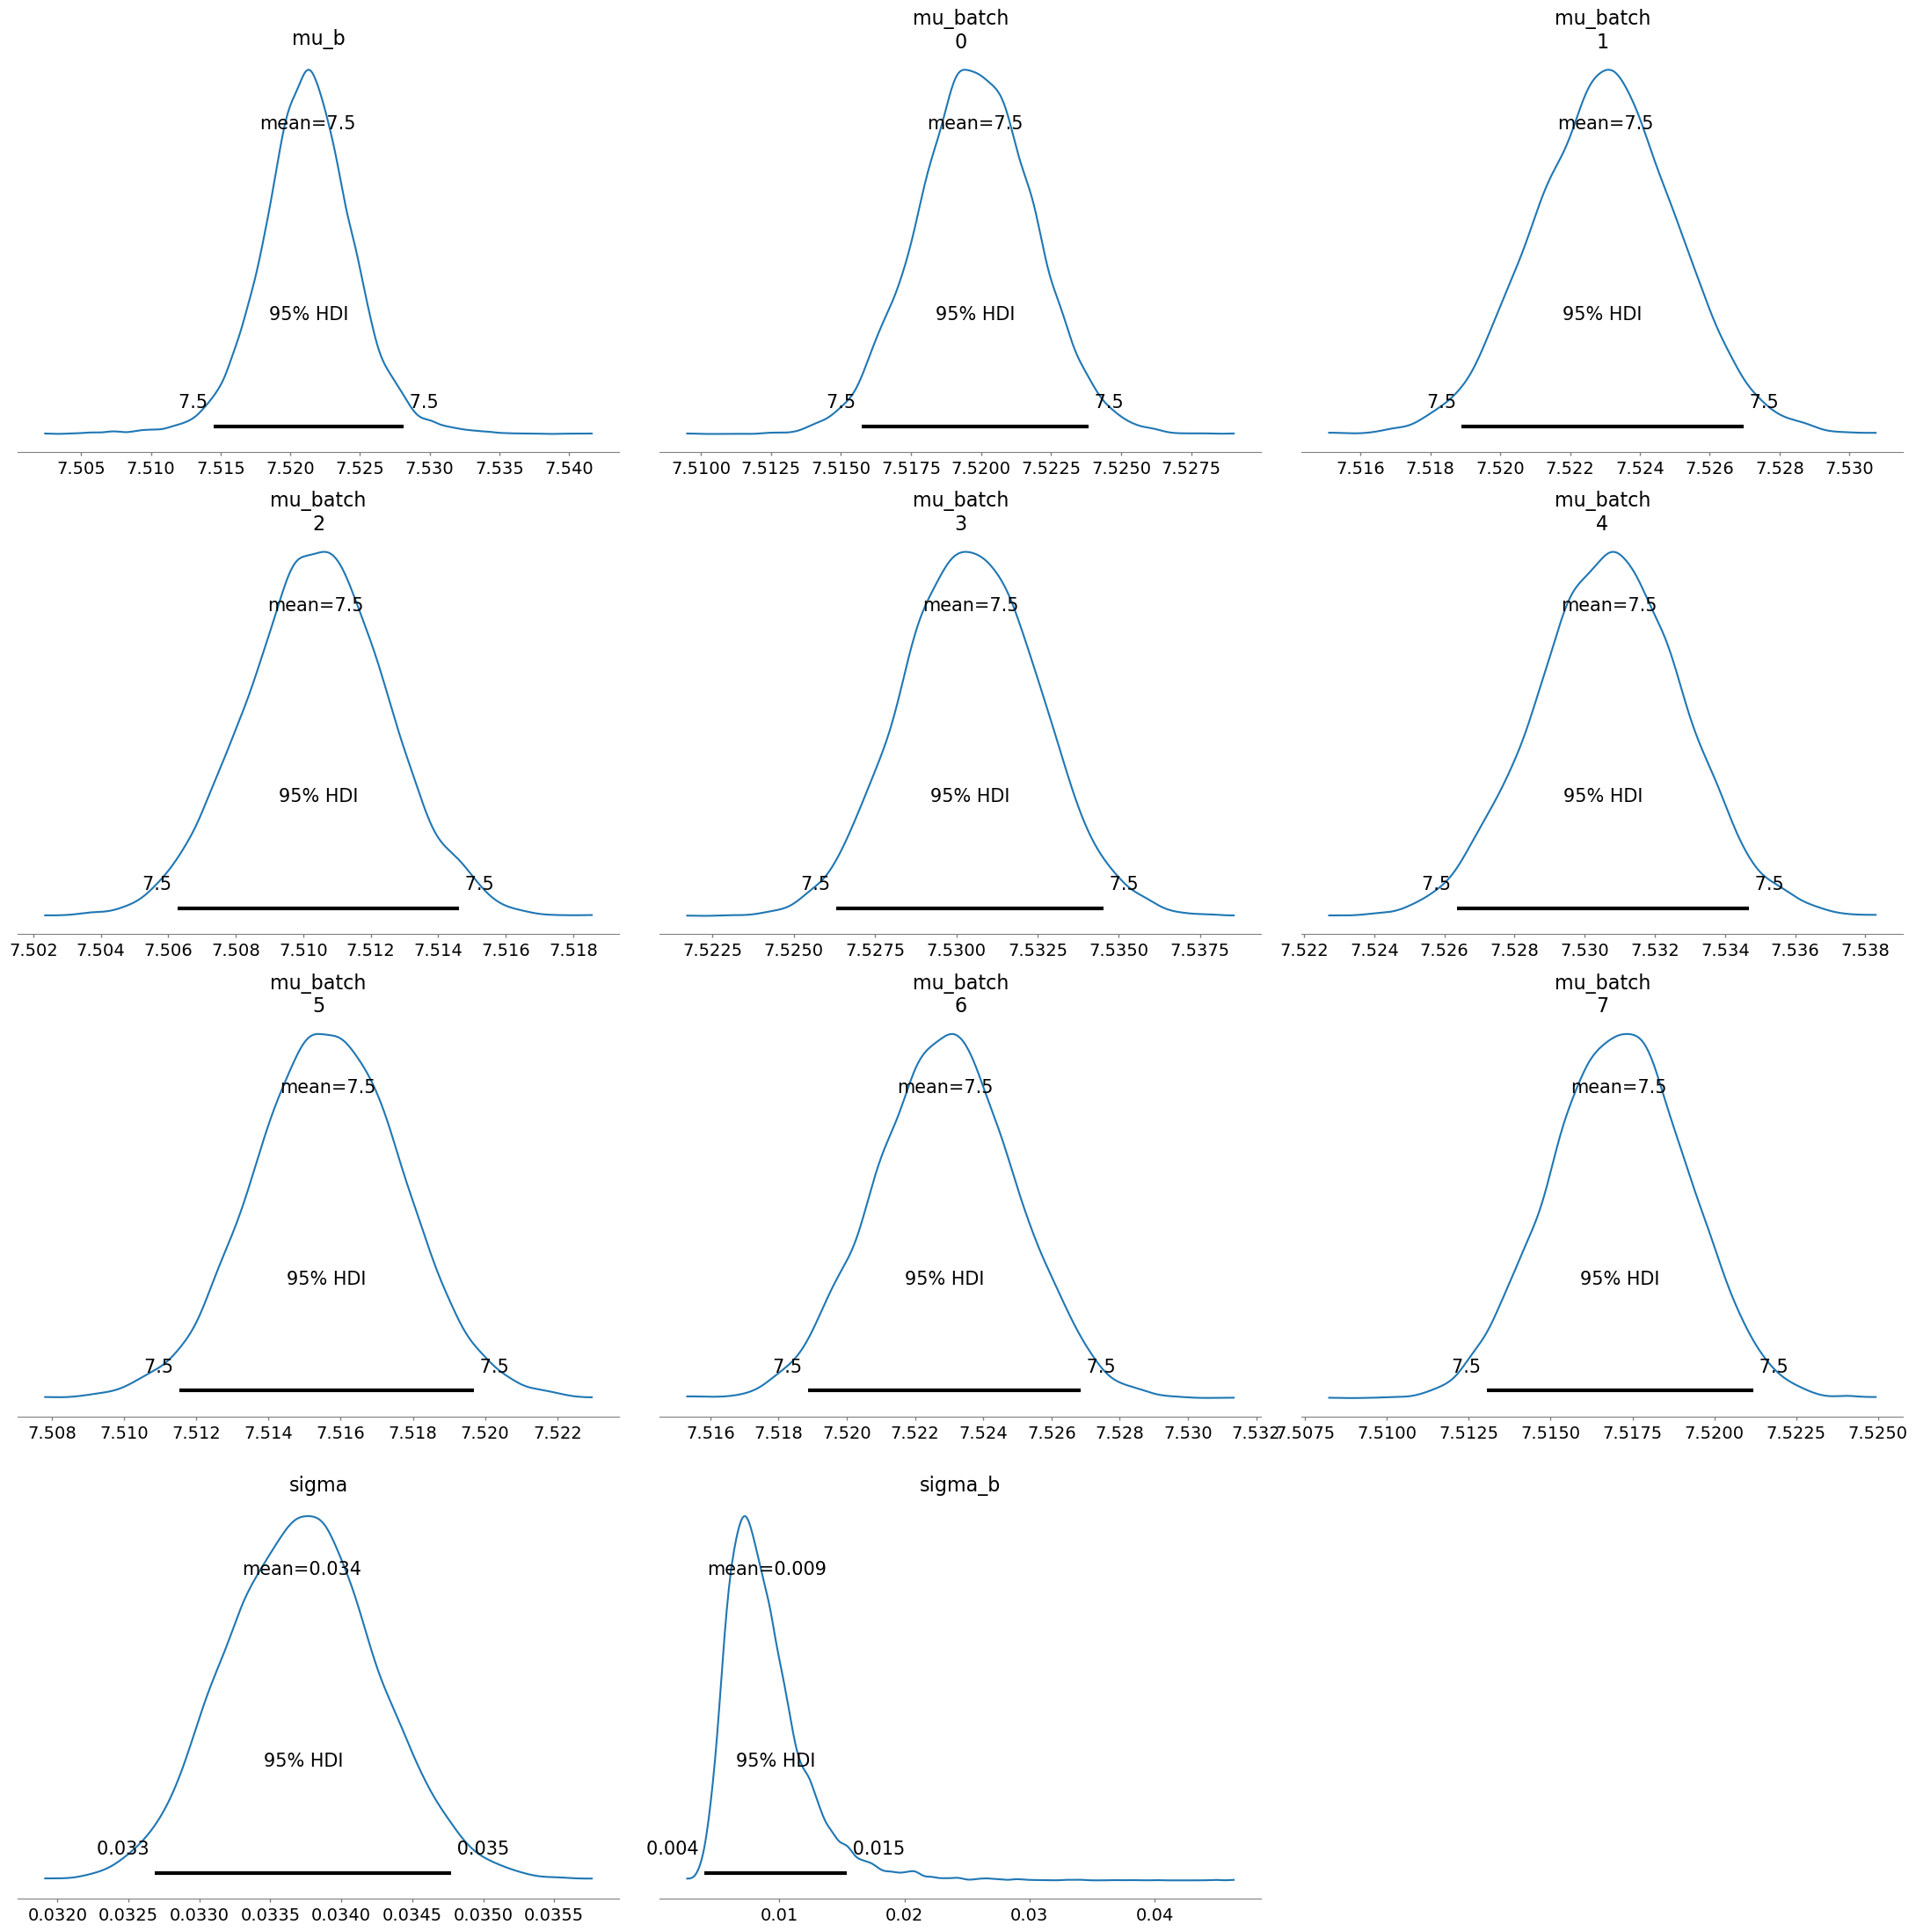

In [20]:
az.plot_posterior(trace, hdi_prob=0.95)
plt.tight_layout()

In [21]:
means_mu = trace.posterior.mu_batch[0].mean('draw')
means_mu.argsort().data

array([2, 5, 7, 0, 6, 1, 3, 4])

In [22]:
with model:
    mu_batch_max_minus_min = pm.Deterministic('mu_batch_max - mu_batch_min', mu_batch[4] - mu_batch[2])

In [23]:
with model:
    trace = pm.sample(draws=1000, nuts_sampler='numpyro')

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [24]:
mu_batch_max_minus_min_hdi = az.hdi(trace, hdi_prob=0.95)['mu_batch_max - mu_batch_min']

In [25]:
print(f'mu_batch_max - mu_batch_min hdi: [{float(mu_batch_max_minus_min_hdi[0]):5f}; {float(mu_batch_max_minus_min_hdi[1]):.5f}]')

mu_batch_max - mu_batch_min hdi: [0.014175; 0.02618]


# 3

In [26]:
data = pd.read_csv('https://stepik.org/media/attachments/lesson/832665/Fish.csv')
data = data.drop(40, axis=0)
print(data.head())

  Species  Weight  Length1  Length2  Length3   Height   Width
0   Bream   242.0     23.2     25.4     30.0  11.5200  4.0200
1   Bream   290.0     24.0     26.3     31.2  12.4800  4.3056
2   Bream   340.0     23.9     26.5     31.1  12.3778  4.6961
3   Bream   363.0     26.3     29.0     33.5  12.7300  4.4555
4   Bream   430.0     26.5     29.0     34.0  12.4440  5.1340


In [27]:
with pm.Model() as fish_model:
    log_length_1 = pm.Data('log_length_1', np.log(data.Length1.values))
    log_height = pm.Data('log_height', np.log(data.Height.values))
    log_width = pm.Data('log_width', np.log(data.Width.values))
    
    betas = pm.Normal('betas', mu=0, sigma=100, shape=4)
    
    sigma = pm.HalfNormal('sigma', 100)
    
    features = pt.stack((
        pt.ones_like(log_length_1),
        log_length_1,
        log_height,
        log_width
    ))
    
    log_weight = pm.Normal('log_weight',
        mu=pm.math.dot(betas, features),
        sigma=sigma, 
        observed=np.log(data.Weight.values)
    )

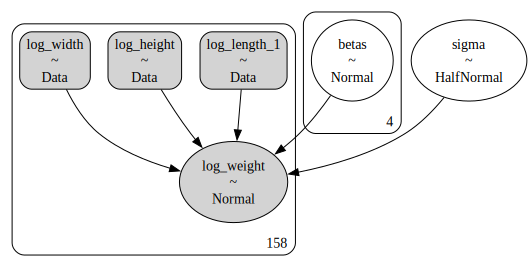

In [28]:
pm.model_to_graphviz(fish_model)

In [29]:
with fish_model:
    trace = pm.sample(draws=10**4, chains=1, nuts_sampler='numpyro')

sample: 100%|██████████| 11000/11000 [00:09<00:00, 1147.82it/s, 39 steps of size 2.91e-02. acc. prob=0.94] 
Only one chain was sampled, this makes it impossible to run some convergence checks


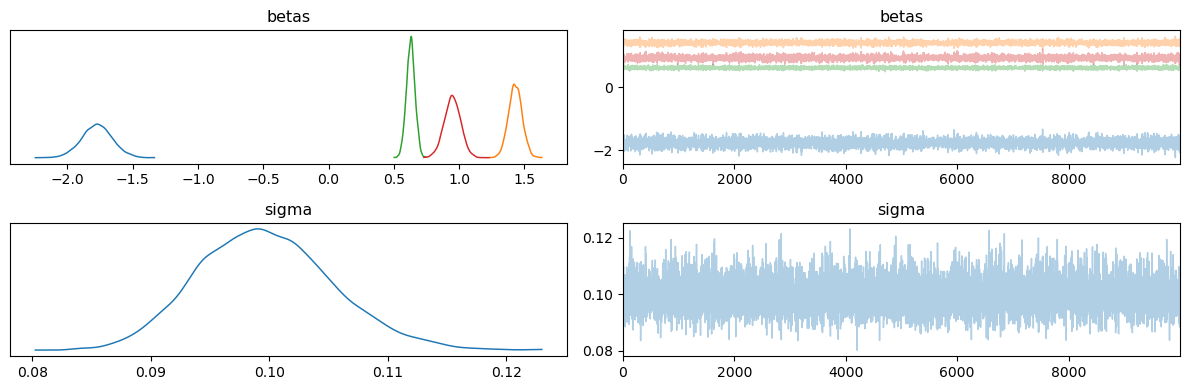

In [30]:
az.plot_trace(trace)
plt.tight_layout()

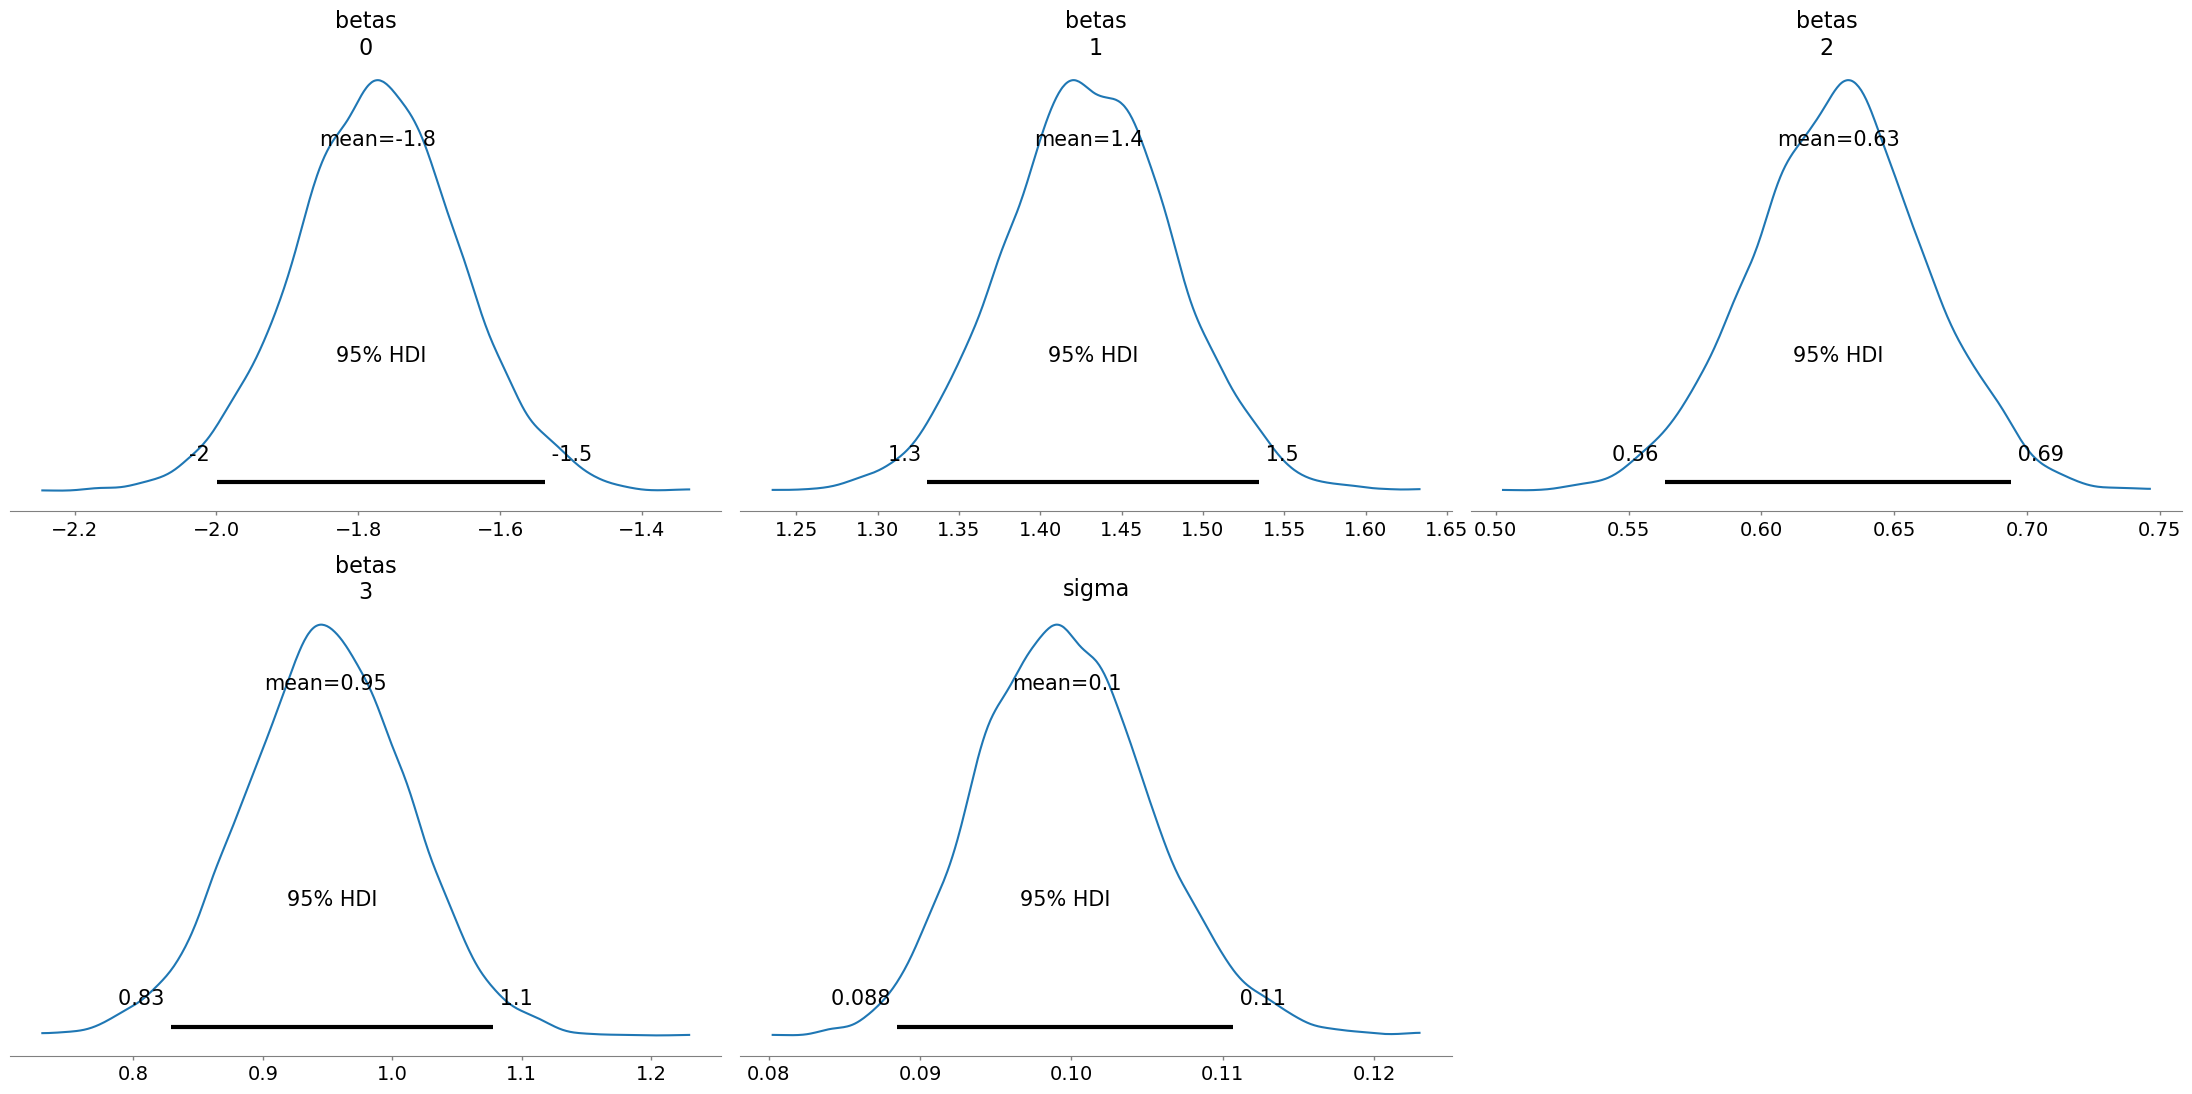

In [31]:
az.plot_posterior(trace, hdi_prob=0.95)
plt.tight_layout()

In [32]:
with fish_model:
    sum_betas_123 = pm.Deterministic('sum(betas[1:])', pm.math.sum(betas[1:]))

In [33]:
with fish_model:
    trace = pm.sample(draws=10**4, chains=1, nuts_sampler='numpyro')

sample: 100%|██████████| 11000/11000 [00:08<00:00, 1293.03it/s, 71 steps of size 3.30e-02. acc. prob=0.94] 
Only one chain was sampled, this makes it impossible to run some convergence checks


In [34]:
sum_betas_123_hdi = az.hdi(trace.posterior['sum(betas[1:])'], hdi_prob=0.95)
print(f'sum(betas[1:]) hdi: [{float(sum_betas_123_hdi['sum(betas[1:])'][0]):5f}; {float(sum_betas_123_hdi['sum(betas[1:])'][1]):.5f}]')

sum(betas[1:]) hdi: [2.968533; 3.04567]


# 4

In [138]:
def average_risk(p1, p2, mu1, cov1, mu2, cov2, n=10**6):
    n1 = int(np.round(p1 * n))
    n2 = n - n1
    
    multivariate_normal_1 = sps.multivariate_normal(mean=mu1, cov=cov1)
    multivariate_normal_2 = sps.multivariate_normal(mean=mu2, cov=cov2)
    x1 = multivariate_normal_1.rvs(n1)
    x2 = multivariate_normal_2.rvs(n2)
    
    pdf_1_x1 = multivariate_normal_1.logpdf(x1)
    pdf_1_x2 = multivariate_normal_1.logpdf(x2)
    
    pdf_2_x1 = multivariate_normal_2.logpdf(x1)
    pdf_2_x2 = multivariate_normal_2.logpdf(x2)
    
    mc_1 = np.sum(np.log(p1) + pdf_1_x1 < np.log(p2) + pdf_2_x1)
    mc_2 = np.sum(np.log(p2) + pdf_2_x2 <= np.log(p1) + pdf_1_x2)
    
    risk = (mc_1 + mc_2) / (n1 + n2)
    
    return risk

In [139]:
average_risk(0.3, 0.7, [0, 0], [[1, 0.5], [0.5, 1]], [2.5, 0], [[1, -0.5], [-0.5, 1]])

np.float64(0.088809)

# 5

In [194]:
n_c = 32
mean_c = 1.013
s2_c = 0.24**2

n_t = 36
mean_t = 1.173
s2_t = 0.20**2

In [195]:
def sample_mu(n, mu, s2, n_samples=10**6):
    sigma2 = (n - 1) * s2 / sps.chi2(df=n-1).rvs(n_samples)
    mu = sps.norm(loc=mu, scale=np.sqrt(sigma2/n)).rvs(n_samples)
    
    return mu

In [196]:
posterior_mu_c = sample_mu(n_c, mean_c, s2_c)
posterior_mu_t = sample_mu(n_t, mean_t, s2_t)

posterior_mu_diff = posterior_mu_t - posterior_mu_c

In [212]:
print(np.quantile(posterior_mu_diff, q=[0.025, 0.975]))

[0.05058838 0.26971169]


In [198]:
with pm.Model() as chicken_model:
    sigma2_c = (n_c - 1) * s2_c / pm.ChiSquared('chi2_c', nu=n_c-1)
    sigma2_t = (n_t - 1) * s2_t / pm.ChiSquared('chi2_t', nu=n_t-1)
    
    mu_c = pm.Normal('mu_c', mu=mean_c, sigma=pm.math.sqrt(sigma2_c/n_c))
    mu_t = pm.Normal('mu_t', mu=mean_t, sigma=pm.math.sqrt(sigma2_t/n_t))
    
    mu_diff = pm.Deterministic('mu_diff', mu_t - mu_c)

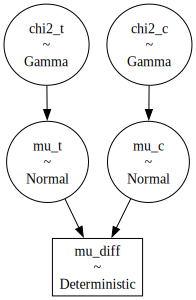

In [199]:
pm.model_to_graphviz(chicken_model)

In [210]:
with chicken_model:
    trace = pm.sample(draws=10**3, chains=4)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chi2_c, chi2_t, mu_c, mu_t]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


In [211]:
mu_diff_hdi = pm.hdi(trace.posterior.mu_diff, 0.95)
print(f'mu_t - mu_c hdi: [{float(mu_diff_hdi['mu_diff'][0]):5f}; {float(mu_diff_hdi['mu_diff'][1]):.5f}]')

mu_t - mu_c hdi: [0.051495; 0.27191]
